In [1]:
import pandas as pd
import psycopg2
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import auc_model

In [3]:
def savePearson(pearson,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO wordspearson(word,p1,p2,patient,deadPatient)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(p1)s) ,'
                      ' unnest( %(p2)s) ,'
                      ' unnest( %(patient)s) ,'
                      ' unnest( %(deadPatient)s)')
    word=[r['word'] for r in pearson]
    p1=[r['p1'] for r in pearson]
    p2=[r['p2'] for r in pearson]
    patient=[r['patient'] for r in pearson]
    deadPatient=[r['deadPatient'] for r in pearson]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [4]:
def selectPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT word,p1,p2,patient,deadpatient FROM wordspearson'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement)
    select = []
    for row in cur :
        patient=row[3]
        cuantosMueren ="{0:.2%}".format(row[4]/patient)+" de "+str(patient)
        select.append({"word":row[0],"p1":row[1],"p2":row[2],"cuantosMueren":cuantosMueren})
    cur.close()
    conn.close()
    return select

In [5]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [6]:
def cleanPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    delete_statement='DELETE FROM wordspearson'
#    print(cur.mogrify(delete_statement,locals()))
    cur.execute(delete_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [7]:
table = convert_matrix(sumvals=False)
print(table.shape)
table

(590, 18683)
(590, 18683)


,,aaaaac,aaaaad,aaaaae,aaaaaf,aaaaag,aaaaah,aaaaai,aaaaaj,aaaabb,aaaabc,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
135,1,0,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
177,1,0,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
214,1,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
263,1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
283,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
survived = table.index.labels[1].tolist()
patients = table.values
columns = list(table.columns.values)

In [9]:
cleanPearson()
print("cleanedPearson now reading",len(columns),"columns")
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    pearsonList.append({'word':word,'p1':pearson[0],'p2':pearson[1],'patient':count['patient'],'deadPatient':count['deadPatient']})
    print(i,end=", ")
print(" preparedToSavePearson")
savePearson(pearsonList)
print("savedPearson")

cleanedPearson now reading 18683 columns


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718

2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085

4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453

5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5818, 5819

7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186

8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552

9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918

10958, 10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992, 10993, 10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100,

12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12238, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12267, 12268, 12269, 12270, 12271, 12272,

13301, 13302, 13303, 13304, 13305, 13306, 13307, 13308, 13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13321, 13322, 13323, 13324, 13325, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13406, 13407, 13408, 13409, 13410, 13411, 13412, 13413, 13414, 13415, 13416, 13417, 13418, 13419, 13420, 13421, 13422, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434, 13435, 13436, 13437, 13438, 13439, 13440, 13441, 13442, 13443,

14472, 14473, 14474, 14475, 14476, 14477, 14478, 14479, 14480, 14481, 14482, 14483, 14484, 14485, 14486, 14487, 14488, 14489, 14490, 14491, 14492, 14493, 14494, 14495, 14496, 14497, 14498, 14499, 14500, 14501, 14502, 14503, 14504, 14505, 14506, 14507, 14508, 14509, 14510, 14511, 14512, 14513, 14514, 14515, 14516, 14517, 14518, 14519, 14520, 14521, 14522, 14523, 14524, 14525, 14526, 14527, 14528, 14529, 14530, 14531, 14532, 14533, 14534, 14535, 14536, 14537, 14538, 14539, 14540, 14541, 14542, 14543, 14544, 14545, 14546, 14547, 14548, 14549, 14550, 14551, 14552, 14553, 14554, 14555, 14556, 14557, 14558, 14559, 14560, 14561, 14562, 14563, 14564, 14565, 14566, 14567, 14568, 14569, 14570, 14571, 14572, 14573, 14574, 14575, 14576, 14577, 14578, 14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587, 14588, 14589, 14590, 14591, 14592, 14593, 14594, 14595, 14596, 14597, 14598, 14599, 14600, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14614,

15644, 15645, 15646, 15647, 15648, 15649, 15650, 15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659, 15660, 15661, 15662, 15663, 15664, 15665, 15666, 15667, 15668, 15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677, 15678, 15679, 15680, 15681, 15682, 15683, 15684, 15685, 15686, 15687, 15688, 15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699, 15700, 15701, 15702, 15703, 15704, 15705, 15706, 15707, 15708, 15709, 15710, 15711, 15712, 15713, 15714, 15715, 15716, 15717, 15718, 15719, 15720, 15721, 15722, 15723, 15724, 15725, 15726, 15727, 15728, 15729, 15730, 15731, 15732, 15733, 15734, 15735, 15736, 15737, 15738, 15739, 15740, 15741, 15742, 15743, 15744, 15745, 15746, 15747, 15748, 15749, 15750, 15751, 15752, 15753, 15754, 15755, 15756, 15757, 15758, 15759, 15760, 15761, 15762, 15763, 15764, 15765, 15766, 15767, 15768, 15769, 15770, 15771, 15772, 15773, 15774, 15775, 15776, 15777, 15778, 15779, 15780, 15781, 15782, 15783, 15784, 15785, 15786,

16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825, 16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843, 16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864, 16865, 16866, 16867, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16888, 16889, 16890, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16954, 16955, 16956, 16957,

17986, 17987, 17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997, 17998, 17999, 18000, 18001, 18002, 18003, 18004, 18005, 18006, 18007, 18008, 18009, 18010, 18011, 18012, 18013, 18014, 18015, 18016, 18017, 18018, 18019, 18020, 18021, 18022, 18023, 18024, 18025, 18026, 18027, 18028, 18029, 18030, 18031, 18032, 18033, 18034, 18035, 18036, 18037, 18038, 18039, 18040, 18041, 18042, 18043, 18044, 18045, 18046, 18047, 18048, 18049, 18050, 18051, 18052, 18053, 18054, 18055, 18056, 18057, 18058, 18059, 18060, 18061, 18062, 18063, 18064, 18065, 18066, 18067, 18068, 18069, 18070, 18071, 18072, 18073, 18074, 18075, 18076, 18077, 18078, 18079, 18080, 18081, 18082, 18083, 18084, 18085, 18086, 18087, 18088, 18089, 18090, 18091, 18092, 18093, 18094, 18095, 18096, 18097, 18098, 18099, 18100, 18101, 18102, 18103, 18104, 18105, 18106, 18107, 18108, 18109, 18110, 18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120, 18121, 18122, 18123, 18124, 18125, 18126, 18127, 18128,

In [10]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [11]:
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(590, 18683)
(472, 18683)
(118, 18683)


In [12]:
model,accuracy_score = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 73.73%


In [13]:
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

Logistic AUC = 0.4782f


In [14]:
model

LogisticRegressionCV(Cs=[0.011143, 0.0113212, 0.0114994, 0.0116776, 0.0118558, 0.012034],
           class_weight=None, cv=5, dual=True, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=0, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

In [15]:
from operator import itemgetter
pearsonDict = selectPearson()
pearsonDict = sorted(pearsonDict, key=itemgetter('p1'), reverse=True)

[{'cuantosMueren': '89.68% de 155', 'p2': 3.06102185441199e-07, 'word': 'adc', 'p1': 0.208886190046134}, {'cuantosMueren': '96.39% de 83', 'p2': 5.97981161316011e-07, 'word': 'fdf', 'p1': 0.203783764475214}, {'cuantosMueren': '85.07% de 221', 'p2': 3.75580792778002e-06, 'word': 'dbda', 'p1': 0.189067111670612}, {'cuantosMueren': '87.27% de 165', 'p2': 7.08939354448729e-06, 'word': 'fbd', 'p1': 0.183704825193073}, {'cuantosMueren': '93.18% de 88', 'p2': 1.0711840622015e-05, 'word': 'dff', 'p1': 0.180136446835082}]


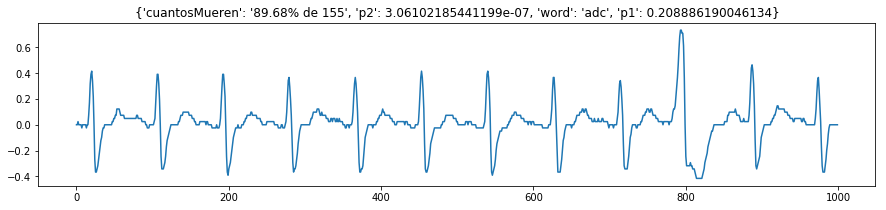

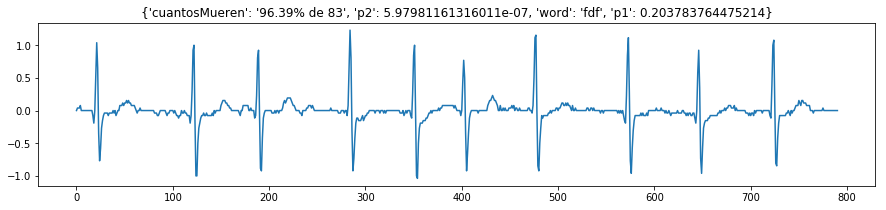

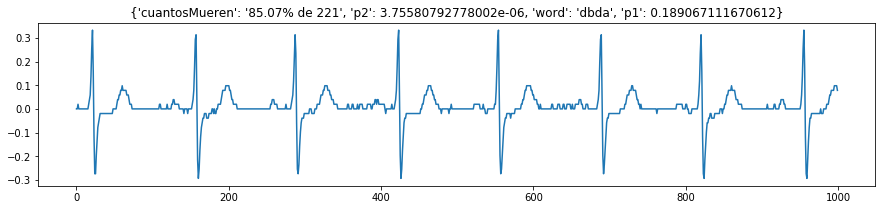

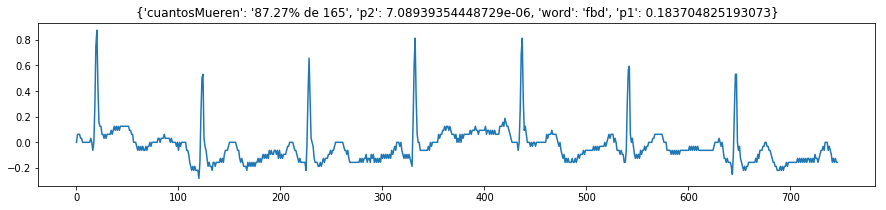

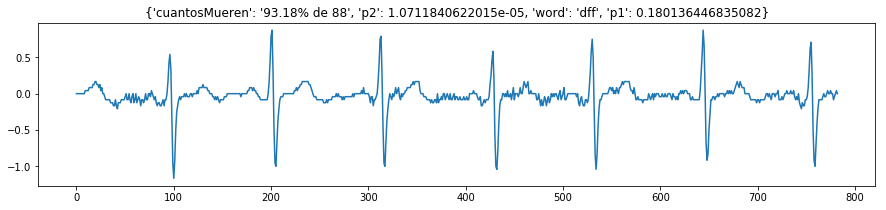

In [16]:
print(pearsonDict[:5])
plot_word(pearsonDict[:5])